In [1]:
from ultralytics import YOLO
import numpy as np
from PIL import Image
import cv2

model = YOLO('yolov8x.pt')  # Load a pretrained YOLOv8 model
model.info()

YOLOv8x summary: 365 layers, 68,229,648 parameters, 0 gradients, 258.5 GFLOPs


(365, 68229648, 0, 258.5472512)


image 1/1 /Users/harry/Desktop/Nothing/sky/scenic-reasoning/demo/demo.jpg: 448x640 18 cars, 2 benchs, 289.8ms
Speed: 1.5ms preprocess, 289.8ms inference, 6.7ms postprocess per image at shape (1, 3, 448, 640)
Predicted bench with confidence 0.962 at tensor([[222.0089, 175.3375, 456.1030, 382.1310]])
Predicted car with confidence 0.908 at tensor([[295.3603, 116.0550, 378.7220, 150.4118]])
Predicted car with confidence 0.903 at tensor([[191.2909, 108.9104, 299.1893, 155.4361]])
Predicted car with confidence 0.891 at tensor([[431.4721, 104.8091, 484.0837, 131.8983]])
Predicted car with confidence 0.868 at tensor([[481.3361, 110.3898, 522.8889, 130.2433]])
Predicted car with confidence 0.844 at tensor([[265.9401, 105.3029, 326.0040, 127.6179]])
Predicted car with confidence 0.820 at tensor([[167.4330, 109.0410, 212.1043, 139.9360]])
Predicted car with confidence 0.808 at tensor([[375.6009, 110.6982, 432.6725, 133.6223]])
Predicted car with confidence 0.805 at tensor([[554.6240, 109.9193, 5

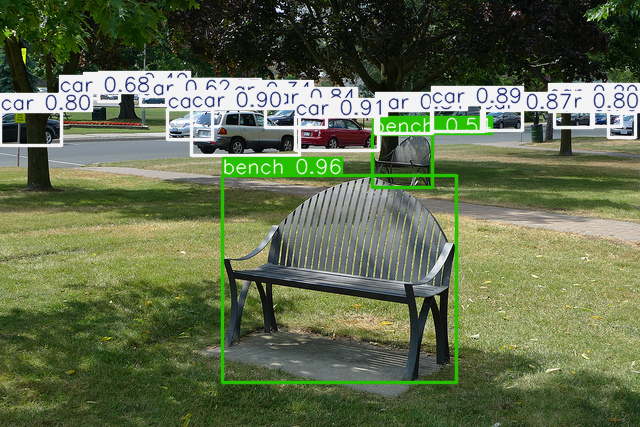

In [2]:
image_path = '/Users/harry/Desktop/Nothing/sky/scenic-reasoning/demo/demo.jpg'
results = model(image_path)

for result in results:
    boxes = result.boxes
    names = result.names
    
    for box in boxes:
        name = int(box.cls)
        confidence = float(box.conf)
        coord = box.xyxy # tensor of (x1, y1, x2, y2)
        print(f"Predicted {names[name]} with confidence {confidence:.3f} at {coord}")

tensor = results[0].plot()
# show the tensor as an image
from PIL import Image

# convert tensor from BGR to RGB
tensor = tensor[:, :, ::-1]

img = Image.fromarray(tensor, mode='RGB')
img

In [3]:
seg_model = YOLO('/Users/harry/Desktop/Nothing/sky/scenic-reasoning/notebooks/yolo11n-seg.pt')  # Load a pretrained YOLOv8 model
model.info()

YOLOv8x summary (fused): 268 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


(268, 68200608, 0, 257.8145792)

In [4]:
def segment_image(model, image_path, conf_threshold=0.5):
    results = model(image_path)
    
    return results[0]

def visualize_seg_results(image_path, results):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    masks = results.masks.data.cpu().numpy()
    boxes = results.boxes.data.cpu().numpy()
    cls = results.boxes.cls.cpu().numpy()
    
    # Draw each instance
    for mask, box, class_id in zip(masks, boxes, cls):
        # Resize mask to match image dimensions
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
        binary_mask = mask > 0.5
        
        # Generate random color
        color = np.random.randint(0, 255, size=3).tolist()
        
        # Create color overlay
        color_mask = np.full(img.shape, color, dtype=np.uint8)
        img = np.where(binary_mask[..., None], 
                      cv2.addWeighted(img, 0.5, color_mask, 0.5, 0),
                      img)
        
        # Draw bounding box
        x1, y1, x2, y2 = box[:4].astype(int)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        
        # Add label
        label = f"{results.names[int(class_id)]} {box[4]:.2f}"
        cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    return img.astype(np.uint8)


image 1/1 /Users/harry/Desktop/Nothing/sky/scenic-reasoning/demo/demo.jpg: 448x640 14 cars, 2 benchs, 2 chairs, 47.9ms
Speed: 0.7ms preprocess, 47.9ms inference, 4.7ms postprocess per image at shape (1, 3, 448, 640)


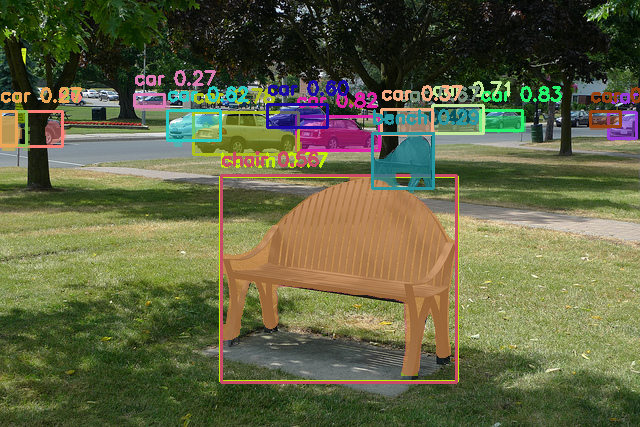

In [5]:
seg_results = segment_image(seg_model,image_path)
seg_annotations = visualize_seg_results(image_path, seg_results)
# print(f"segmentation results: {seg_results}")
# print(f"segmentation results boxes: {seg_results.boxes}")
# print(f"segmentation results masks: {seg_results.masks}")
seg_img = Image.fromarray(seg_annotations, mode='RGB')
seg_img